# Taweret: Multivariate Model Mixing Tutorial

## Author: Alexandra Semposki

### Date: 02 May 2023

---

Welcome to the BAND camp hands-on session with our Bayesian Model Mixing (BMM) package, Taweret! Below we'll look at an interesting toy model that we can apply one of Taweret's many BMM methods to. We'll have short tasks for you along the way so that you can get accustomed to the package and to BMM generally, as well as one of the foundational tools in Machine Learning: __Gaussian Process (GP) emulators__. 

---

Further reading:

*Bayesian data analysis and statistics*

- A. Gelman, J. Carlin, H. Stern, D. Dunson, A. Vehtari, D. Rubin. "Bayesian Data Analysis", 1995. http://www.stat.columbia.edu/~gelman/book/.
- J. S. Sivia, "Data Analysis: A Bayesian Tutorial", Oxford University Press, 2nd Ed., 2006. 

*Gaussian Processes*

- J. A. Melendez, R. J. Furnstahl, D. R. Phillips, M. T. Pratola, and S. Wesolowski, Quantifying Correlated Truncation Errors in Effective Field Theory, Phys. Rev. C 100, 044001 (2019), arXiv:1904.10581 [nucl-th].
- Carl Edward Rasmussen and Christopher K. I. Williams, "Gaussian Processes for Machine Learning", The MIT Press, 2006.

---

## Models

Now, let's start by looking at the models that we'll be using. We want to mix the expansions of the zero-dimensional $\phi^4$-theory partition function, below:

$$
 F(g) = \int_{-\infty}^{\infty} dx~ e^{-\frac{x^{2}}{2} - g^{2} x^{4}} = \frac{e^{\frac{1}{32 g^{2}}}}{2 \sqrt{2}g} K_{\frac{1}{4}}\left(\frac{1}{32 g^{2}} \right).
$$

The two expansions are limits taken at $g = 0$ and $g = \infty$:

$$
F_{s}^{N_s}(g) = \sum_{k=0}^{N_{s}} s_{k} g^{k},
$$

and 

$$
F_{l}^{N_{l}}(g) = \frac{1}{\sqrt{g}} \sum_{k=0}^{N_{l}} l_{k} g^{-k},
$$

with coefficients given as:

$$
s_{2k} = \frac{\sqrt{2} \Gamma{(2k + 1/2)}}{k!} (-4)^{k},~~~~~s_{2k + 1} = 0
$$

and

$$
l_{k} = \frac{\Gamma{\left(\frac{k}{2} + \frac{1}{4}\right)}}{2k!} \left(-\frac{1}{2}\right)^{k}.
$$

We begin by importing all of the Python packages we will need in this Jupyter notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
import statistics
import emcee
import corner
from cycler import cycler
from scipy import stats, special, integrate

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

#matplotlib settings for Latex plots
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

Now we pull in the Taweret package and the models it contains. Below we import from Taweret the __BaseModel__ and __BaseMixer__ classes, which we discussed during the first half of the session. They are the base classes on which Taweret operates, and which allow the user to define models and mixing strategies of their own. 

We are also importing from the `samba_models` file, which contains the toy model we're using.

In [2]:
import sys
sys.path.append('../')

from Taweret.core.base_model import BaseModel
from Taweret.core.base_mixer import BaseMixer

from Taweret.models import samba_models
from samba.gaussprocess import GP

Now we plot the functions we want to mix to see what they look like. We need to first pick a value for $N_{s}$ and $N_{l}$. Let's pick $N_{s}$ = 3 and $N_{l}$ = 3, which means we truncate our series expansions after the third term in each. Our uncertainties are then $\mathcal{O}(g^{4})$.

We must also define the range of our input parameter (coupling constant), $g$.

In [3]:
#define g and series expansions
g = np.linspace(1e-6,1.0,100)
ns = 3
nl = 3

To plot our models and their uncertainties, we look at what functions are available to us in the `samba_models` file. We will first make a `dict` of models and then plot them, calling the classes listed in the `help` information below.

In [4]:
help(samba_models)

Help on module Taweret.models.samba_models in Taweret.models:

NAME
    Taweret.models.samba_models

DESCRIPTION
    # This toy example is copied from Alexandra; SAMBA package
    # : \phi^4 expansion for small and large g :

CLASSES
    Taweret.core.base_model.BaseModel(abc.ABC)
        exp_data
        highorder
        loworder
        true_model
    
    class exp_data(Taweret.core.base_model.BaseModel)
     |  A wrapper for SAMBA data function
     |  
     |  Method resolution order:
     |      exp_data
     |      Taweret.core.base_model.BaseModel
     |      abc.ABC
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  evaluate(self, input_values: <built-in function array>, error=0.01) -> <built-in function array>
     |      Evaluate the mean and error for given input values
     |      
     |      Parameters
     |      ----------
     |      input_values : numpy 1darray
     |          coupling strength (g) values
     |      error : float
   

In [5]:
# call the 'loworder' class to generate the small-g expansion model for N_s = 3
model_1 = samba_models.loworder(ns, error_model='informative')
model_2 = samba_models.highorder(nl, error_model='informative')

In [6]:
# design the dictionary of models
my_models = {
    "1" : model_1,
    "2" : model_2
}

This is great, but how do we *plot* the models using the linspace in $g$ that we specified earlier? We use the function `evaluate`, located in each of the models' classes above.

In [7]:
help(samba_models.loworder.evaluate)

Help on function evaluate in module Taweret.models.samba_models:

evaluate(self, input_values: <built-in function array>) -> <built-in function array>
    Evaluate the mean and error for given input values
    
    Parameters
    ----------
    input_values : numpy 1darray
        coupling strength (g) values
    
    Returns:
    --------
    mean : numpy 1darray
        The mean of the model
    np.sqrt(var) : numpy 1darray
        The truncation error of the model



We can see from the cell above that the `evaluate` gives both the mean and the standard deviation associated with the model's truncation error. Let's evaluate both of our models from the `dict` above, and plot them.

In [8]:
# evaluate the two models
model_results = []

for i in my_models.keys():
    model_results.append(my_models[i].evaluate(g))

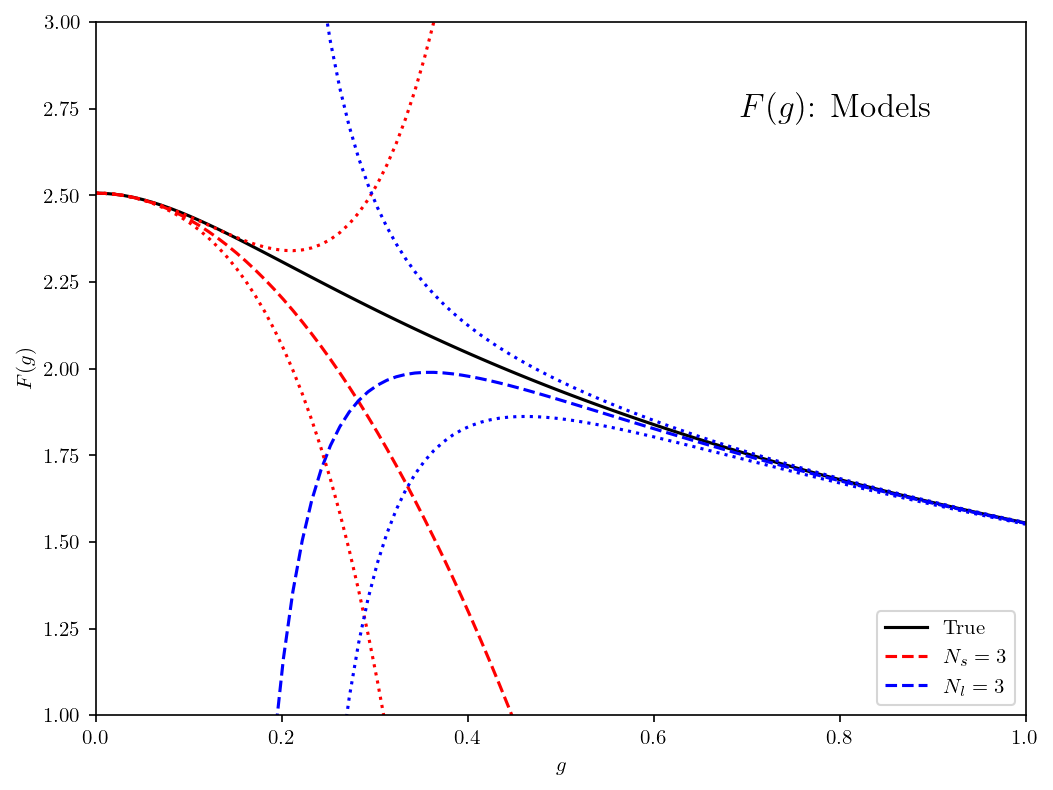

In [9]:
# plot the models
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.0,3.0)
ax.text(0.9,0.9, r'$F(g)$: Models', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$F(g)$')

# color scheme
colors = ['red', 'blue', 'green']

# labels
labels = [r'$N_s = 3$', r'$N_l = 3$']

# lines
lines = ['dashed', 'dotted']

# plot the true model (have them do this part?)
ax.plot(g, samba_models.true_model().evaluate(g)[0].flatten(), color='k', label='True')

# model means
for i in range(len(model_results)):
      ax.plot(g, model_results[i][0].flatten(), color=colors[i], linestyle=lines[0], label=labels[i])
        
# model uncertainties
for i in range(len(model_results)):
    ax.plot(g, model_results[i][0].flatten() - model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    ax.plot(g, model_results[i][0].flatten() + model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    
# legend
ax.legend(loc='lower right')
plt.show()

We can see that the dotted lines show the very large uncertainties we get from higher orders of the expansions. But how do we estimate the truncation error from those terms?

__Add the truncation error scheme here quickly.__

From here, we can actually simply mix these two models together! Using Taweret, we can call the model mixing scheme that will mix the two models using the bivariate model mixing method, where we combine the two models' means and variances like so:

$$
f^{\dagger} \sim \bigl(Z_P^{-1}\sum_k \frac{1}{v_k}f_k, Z_P^{-1}\bigr),
$$

where 

$$
Z_P \equiv \sum_{k=1}^{K}\frac{1}{v_k}.
$$

$Z_P$ is the precision, or the inverse of the variance, of the $K$ models, $v_{k}$ the individual variances of each model (which we previously denoted the theory error), and $f^{\dagger}$ the mixed model.

To mix these models together, we need to instantiate the `Multivariate` class in Taweret.

In [10]:
from Taweret.mix.gaussian import Multivariate

In [11]:
help(Multivariate)

Help on class Multivariate in module Taweret.mix.gaussian:

class Multivariate(Taweret.core.base_mixer.BaseMixer)
 |  Multivariate(x, models, n_models=0)
 |  
 |  The multivariate BMM class originally introduced
 |  in the BAND SAMBA package. Combines individual
 |  models using a Gaussian form. 
 |  
ight) $$
 |  
 |  Example:
 |  --------
 |  ```python
 |  m = Multivariate(x=np.linspace(), models=dict(), n_models=0)
 |  m.predict(ci=68)
 |  m.evaluate_weights()
 |  ```
 |  
 |  Method resolution order:
 |      Multivariate
 |      Taweret.core.base_mixer.BaseMixer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x, models, n_models=0)
 |      Parameters:
 |      -----------
 |      x : numpy.linspace
 |          Input space variable in which mixing is occurring. 
 |      
 |      models : Dict of models with BaseModel methods. 
 |      
 |      n_models : Number of free parameters per model. 
 |      
 |      Returns:
 |      --------
 | 

In [12]:
# call Multivariate
biv_model = Multivariate(g, my_models, n_models=2)

Now we simply use the `predict` function in the `Multivariate` class to produce the mixed model with its mean and uncertainties. We can plot this result below. 

In [13]:
# call predict
_, biv_mean, biv_intervals, biv_std_dev = biv_model.predict(ci=68)

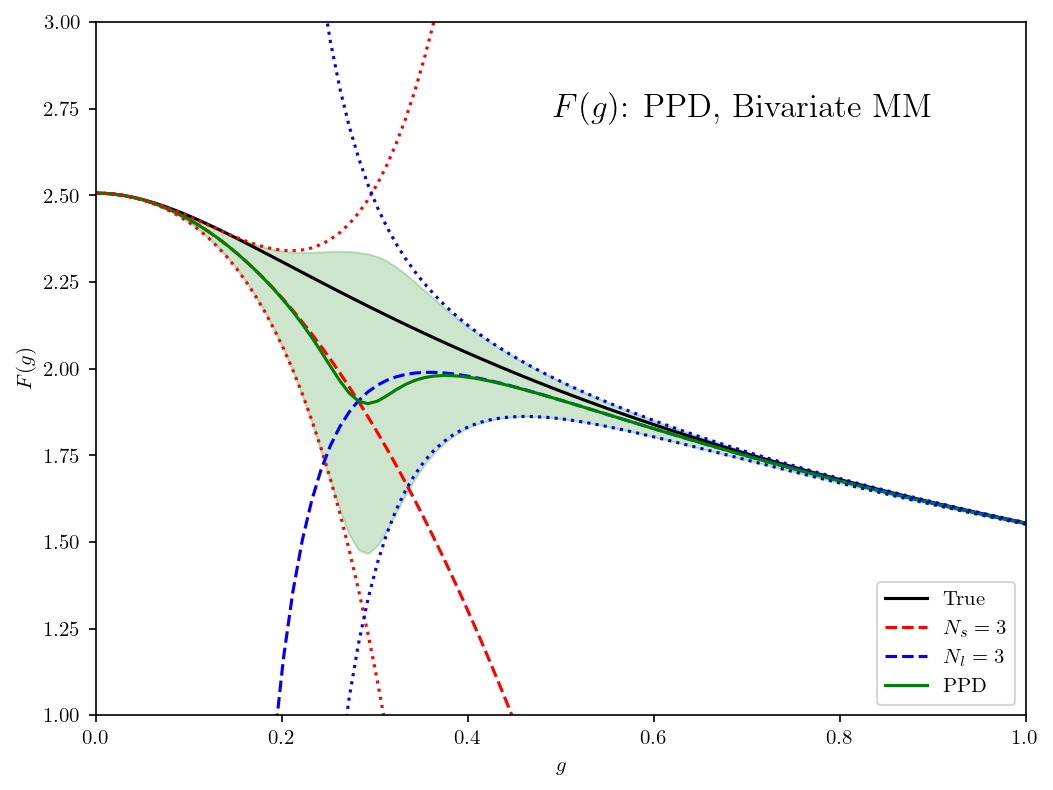

In [14]:
# plot the mixed model
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.0,3.0)
ax.text(0.9,0.9, r'$F(g)$: PPD, Bivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$F(g)$')
ax.plot(g, samba_models.true_model().evaluate(g)[0].flatten(), color='k', label='True')

# model means
for i in range(len(model_results)):
      ax.plot(g, model_results[i][0].flatten(), color=colors[i], linestyle=lines[0], label=labels[i])

# PPD mean
ax.plot(g, biv_mean, color=colors[2], label='PPD')
        
# model uncertainties
for i in range(len(model_results)):
    ax.plot(g, model_results[i][0].flatten() - model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    ax.plot(g, model_results[i][0].flatten() + model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    
# PPD band
ax.fill_between(g, biv_mean-biv_std_dev, biv_mean+biv_std_dev,
                        zorder=i-5, facecolor=colors[2], edgecolor=colors[2], alpha=0.2)

# legend
ax.legend(loc='lower right')
plt.show()

And, as simple as that, there is the mixed model! The green curve is the PPD from the $f^{\dagger}$ equation previously discussed. The credibility interval, in shaded green, is quite large. __Add questions here to explore this.__

In order to fix this (in our toy case) overly conservative band is to implement a GP in the center to take care of some of the interpolation there, where we do not have any prior information other than the variances of the series expansions (shown in dotted red and blue above). That will be the subject of the next section of this tutorial.

### Weights: bivariate MM

Now we'd like to look at what the location-dependent weights show us. What are the __weights__ of the models? These are simply the inverse of their variances (the precision, to be precise). These weights show which model dominates in which region of the input space, and they do so point-by-point, having been calculated at each chosen point in the input space. They are plotted below for the two models above.

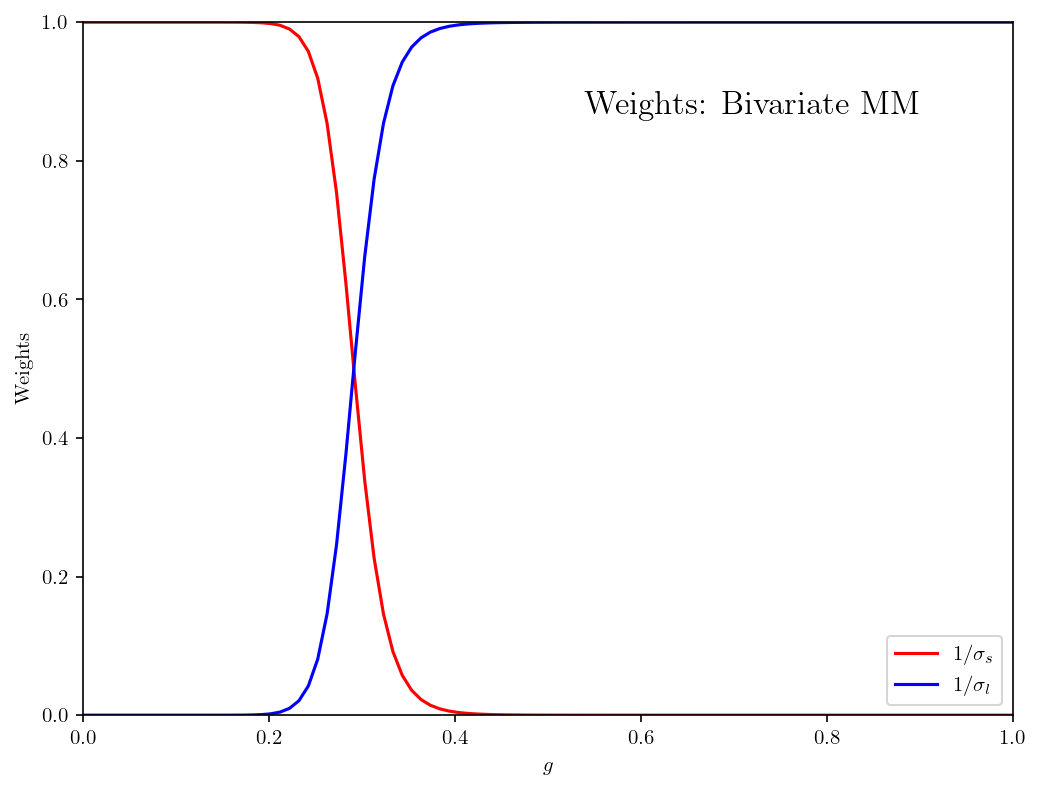

In [15]:
# call the evaluate_weights function
biv_weights = biv_model.evaluate_weights()

labels_weights = [r'$1/\sigma_{s}$', r'$1/\sigma_{l}$']

# plot the weights
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
ax.text(0.9,0.9, 'Weights: Bivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel('Weights')

# model weights
for i in range(len(biv_weights)):
    ax.plot(g, biv_weights[i], color=colors[i], label=labels_weights[i])

# legend
ax.legend(loc='lower right')
plt.show()

__Question__: Does the result above make sense, based on which model is dominant in which region?

---

## Multivariate Model Mixing: Adding a GP

We'd like to improve our results above, so we will employ a __Gaussian Process__. Gaussian processes are non-parametric emulators that can be used for interpolation and regression. They possess tunable hyperparameters that we can calibrate to improve the GP fit and predict capabilities. 

Much like a neural network (and in fact it is the limit of one) a GP requires training data to calibrate it, and testing data to predict results at new data points. Their form consists of a mean function, $m(x)$, and a covariance function, $\kappa(x,x')$. Usually the mean function is taken to be zero, though that can be altered if needed. The covariance function is usually a function of the Euclidean distance between the points $x$ and $x'$, which we term __stationary kernels__ of our GP.(As you can probably imagine, a covariance function that does *not* depend on |$x-x'$| but instead on $x$ is a __non-stationary kernel__, but we don't need to worry about these here.) From the name, the covariance function is the crucial component of the GP that captures correlations in the data, and must be positive semi-definite. We can mathematically write a GP down as

$$
\textbf{f}|\textbf{x} = \mathcal{N}(\textbf{m}, \textit{K}),
$$
where $\textbf{m} = m(\textbf{x})$ and $\textit{K} = \kappa(\textbf{x}, \textbf{x})$, and $\textbf{f}$ is a training set of data corresponding to training points $\textbf{x}$.

Here, we employ the well-known Python package `scikit-learn`, which allows the user the pick from multiple forms of the covariance function to set the __prior__ of the GP. Let's look at some of the options there.

In [16]:
# import scikit learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

# show the options for kernels
help(kernels)

Help on module sklearn.gaussian_process.kernels in sklearn.gaussian_process:

NAME
    sklearn.gaussian_process.kernels - Kernels for Gaussian process regression and classification.

DESCRIPTION
    The kernels in this module allow kernel-engineering, i.e., they can be
    combined via the "+" and "*" operators or be exponentiated with a scalar
    via "**". These sum and product expressions can also contain scalar values,
    which are automatically converted to a constant kernel.
    
    All kernels allow (analytic) gradient-based hyperparameter optimization.
    The space of hyperparameters can be specified by giving lower und upper
    boundaries for the value of each hyperparameter (the search space is thus
    rectangular). Instead of specifying bounds, hyperparameters can also be
    declared to be "fixed", which causes these hyperparameters to be excluded from
    optimization.

CLASSES
    builtins.object
        GenericKernelMixin
        Kernel
            CompoundKernel
  

Looking above through the `help` information, we can spot the types of stationary kernels scikit-learn can call and implement: 
- ConstantKernel
- RBF
- ExpSineSquared
- RationalQuadratic
- Matern
- WhiteKernel

Let's pull some samples from one of them to see what the form of the kernel looks like. 

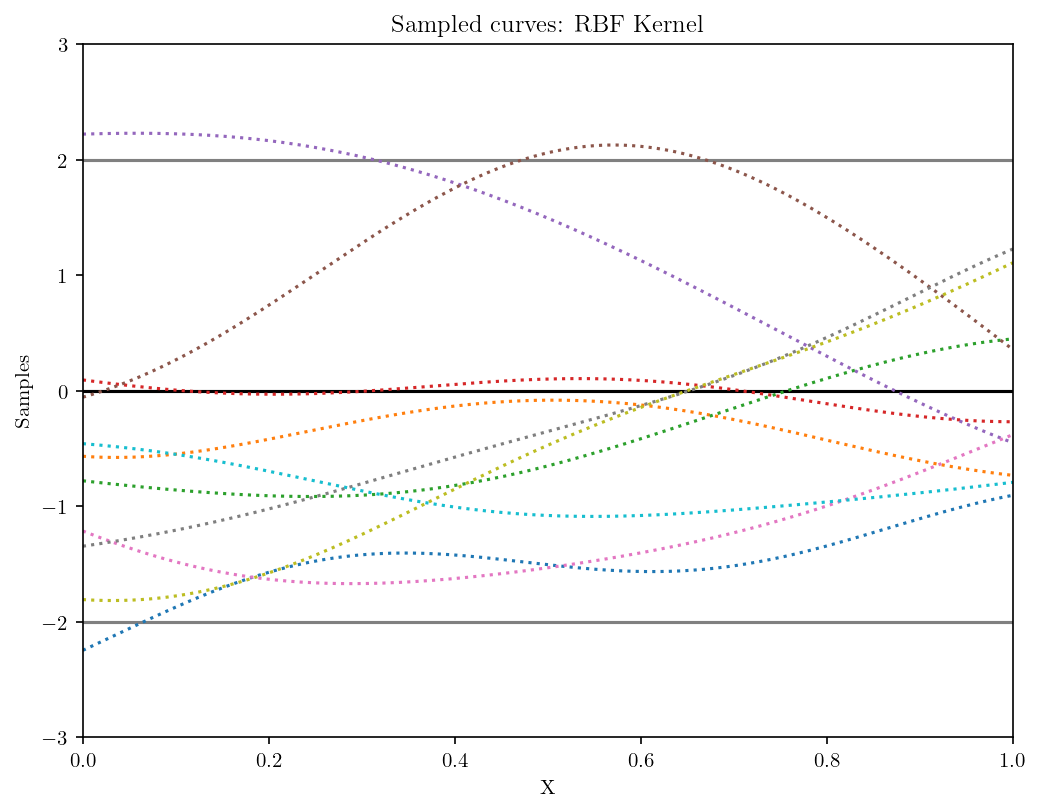

In [17]:
# set up the RBF kernel
kern = kernels.RBF(length_scale=0.4)
gpr = GaussianProcessRegressor(kern)

x = np.linspace(0.0,1.0,500)
X = x[:,None]

# sample from the prior (kernel)
n_samples = 10
samples = gpr.sample_y(X, n_samples=10)

# plot these samples
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Samples')
ax.set_xlim(0.0,1.0)
ax.set_ylim(-3.0,3.0)
ax.set_title('Sampled curves: RBF Kernel')
    
# plot the mean and variance levels
ax.axhline(y=0, color='k')
ax.axhline(y=2, color='grey')
ax.axhline(y=-2, color='grey')

# plot the samples
for i in range(n_samples):
    ax.plot(X, samples[:,i], linestyle='dotted')

The grey lines correspond to the 2$\sigma$ variance level, and the mean function is at y = 0 (black line). From this sampling, we can see that the curves from the RBF kernel are very smooth---*too* smooth, in fact, for some applications, as we'll see later on.

Now, let's try to use one of these GPs to interpolate between the two models in the toy case, and see how our results change. Why would we want to do this? Because GPs can be used to build in important physics and constraints on the system, which would be very useful in a real-world application. 

How do we include the GP as a third model? We simply use the formula defined at the top of this notebook, which we copy here again:

$$
f^{\dagger} \sim \bigl(Z_P^{-1}\sum_k \frac{1}{v_k}f_k, Z_P^{-1}\bigr),
$$

where 

$$
Z_P \equiv \sum_{k=1}^{K}\frac{1}{v_k}.
$$

$Z_P$ is the precision, or the inverse of the variance, of the $K$ models, $v_{k}$ the individual variances of each model (which we previously denoted the theory error), and $f^{\dagger}$ the mixed model.

---

### Writing a model class for the GP

To use a GP as a third model, we need to include it in the model `dict` that we previously created. To do this, we actually need to instantiate a model class that includes the GP and conforms to the necessary `BaseModel` requirements. This is done below. 

We first need to write the `GaussianProcessRegressor` object so that we can train the GP. This class takes the arguments `kernel`, which we already know, `n_restarts_optimizer`, which indicates how many different starting points to use when optimizing the hyperparameters, and `normalize_y`, a Boolean variable that determines whether $m(x)$ (the mean function) is zero or the mean of the data set we use. All of this is wrapped below in the GPModel class. If you would like to play with these parameters, or just look at how we formulate this GP code in more detail, check out the SAMBA package we're wrapping below [here](https://github.com/asemposki/SAMBA). __Make some of the model class writing an exercise.__

In [18]:
# begin the model class with an __init__ function that takes
# the kernel and the input space range
class GPModel: 
    
    # init function sets up the GP
    # nu = value for Matern kernel (root of Bessel function)
    def __init__(self, g, ns, nl, kernel='RBF', nu=0, ci=68, error_model='informative'):
        
        self.g = g
        self.ns = ns
        self.nl = nl
        
        # set up the GP class object with our model orders and chosen kernel
        self.gpmodel = GP(self.g, self.ns, self.nl, kernel=kernel, \
                          nu=nu, ci=ci, error_model=error_model)
        
        return None
    
    # evaluate function for fitting and predicting
    def evaluate(self, g):
        
        # train the GP
        # plot the result
        gpfit = self.gpmodel.training(error=True, method=2, plot=True)
        
        # validate the GP and return mean, std dev, and covariance
        # plot the result
        mean, sig, cov = self.gpmodel.validate(plot=True)
        
        return mean, sig
    
    # to comply with BaseModel, write the log_likelihood function
    def log_likelihood_elementwise(self):
        return None
    
    # to comply with BaseModel, write the set_prior function
    def set_prior(self):
        return None

Because the toy models we are using vary greatly in the speed with which they approach $\pm \infty$ depending on the truncation orders chosen, we must use a detailed training set generator function that determines where to place the points for the GP to train on without straying too far into the region where we do not know much about the function (the ''gap'' in the middle of the plot from previously). Hence, we're wrapping our code from [our paper](https://arxiv.org/abs/2206.04116) to do this quickly here.

Now we can call the above class and see what happens. Once we do this, we can store the mean and standard deviation from this model in the models `dict` and use Taweret to mix all three of them.

In [19]:
# call the GP model and set the object
gp_model = GPModel(g, ns, nl, kernel='Matern', nu=1.5, ci=68)

# redefine the dict of models
my_models = {
    "1" : model_1,
    "2" : model_2,
    "3" : gp_model
}

Finally, we're ready to mix. Below, you'll see plots of the training and testing data results, including the optimized kernel parameters.

Gaussian process parameters: 2.3**2 * Matern(length_scale=2.14, nu=1.5)


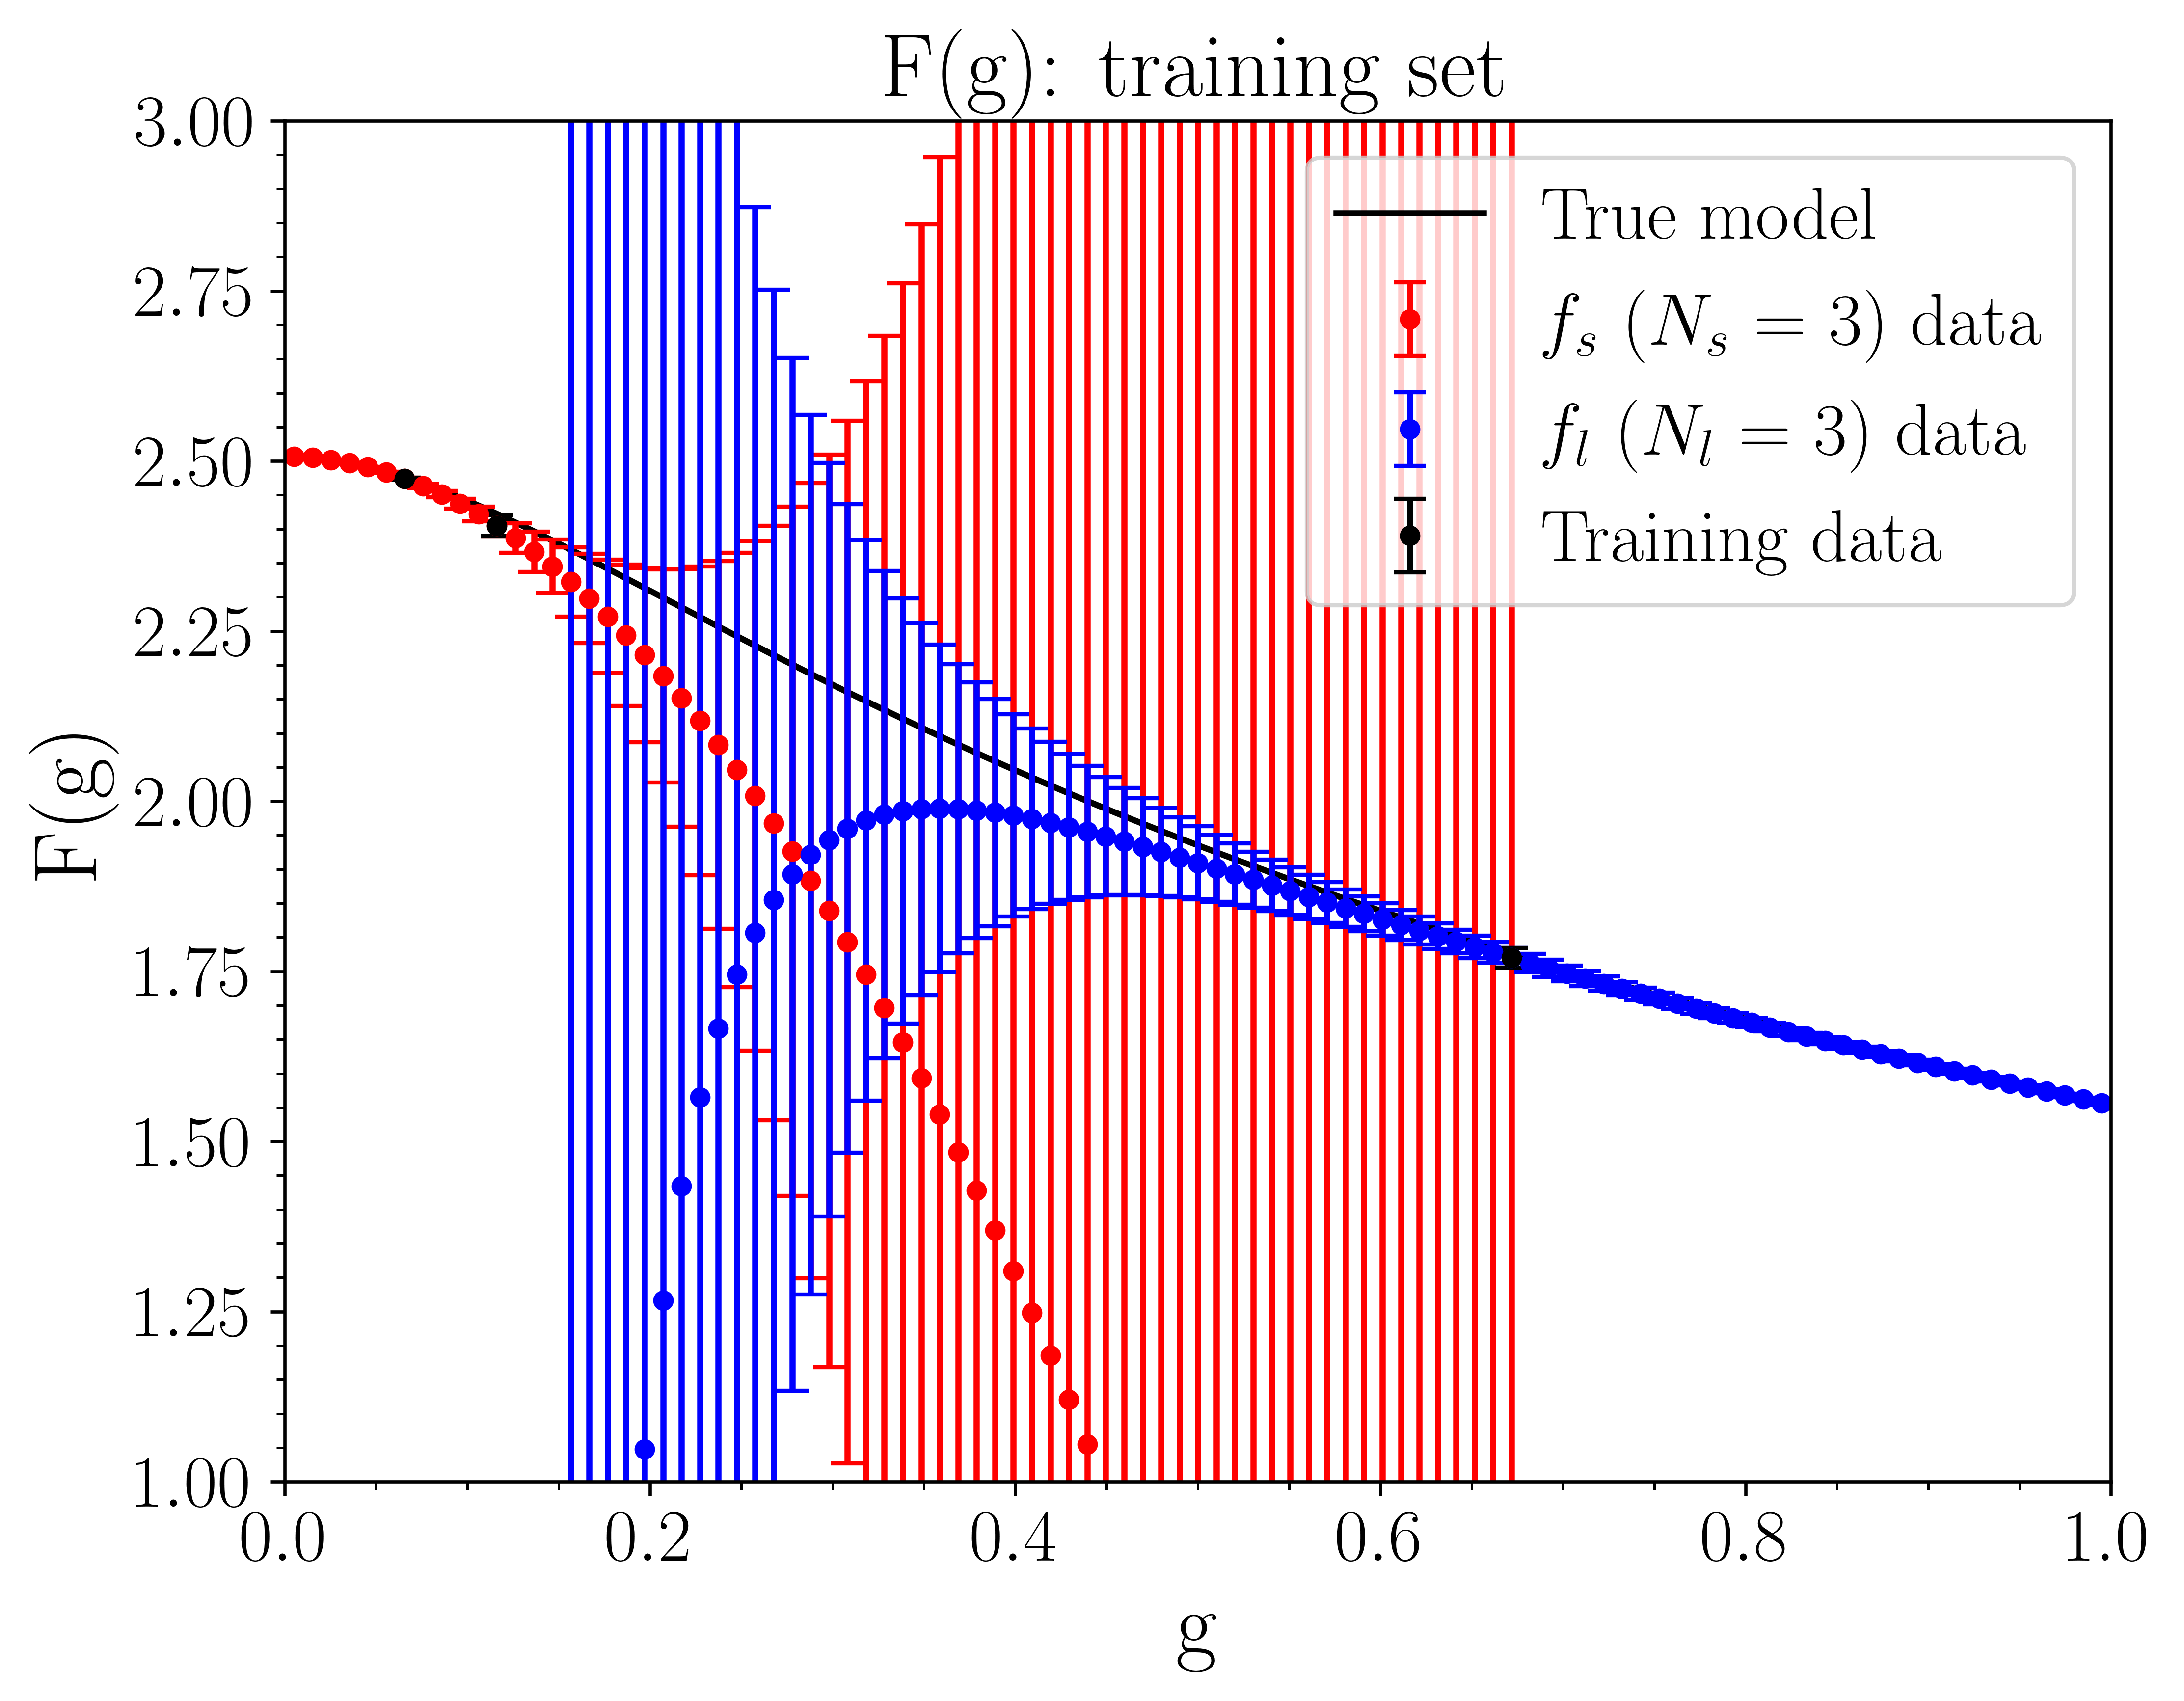

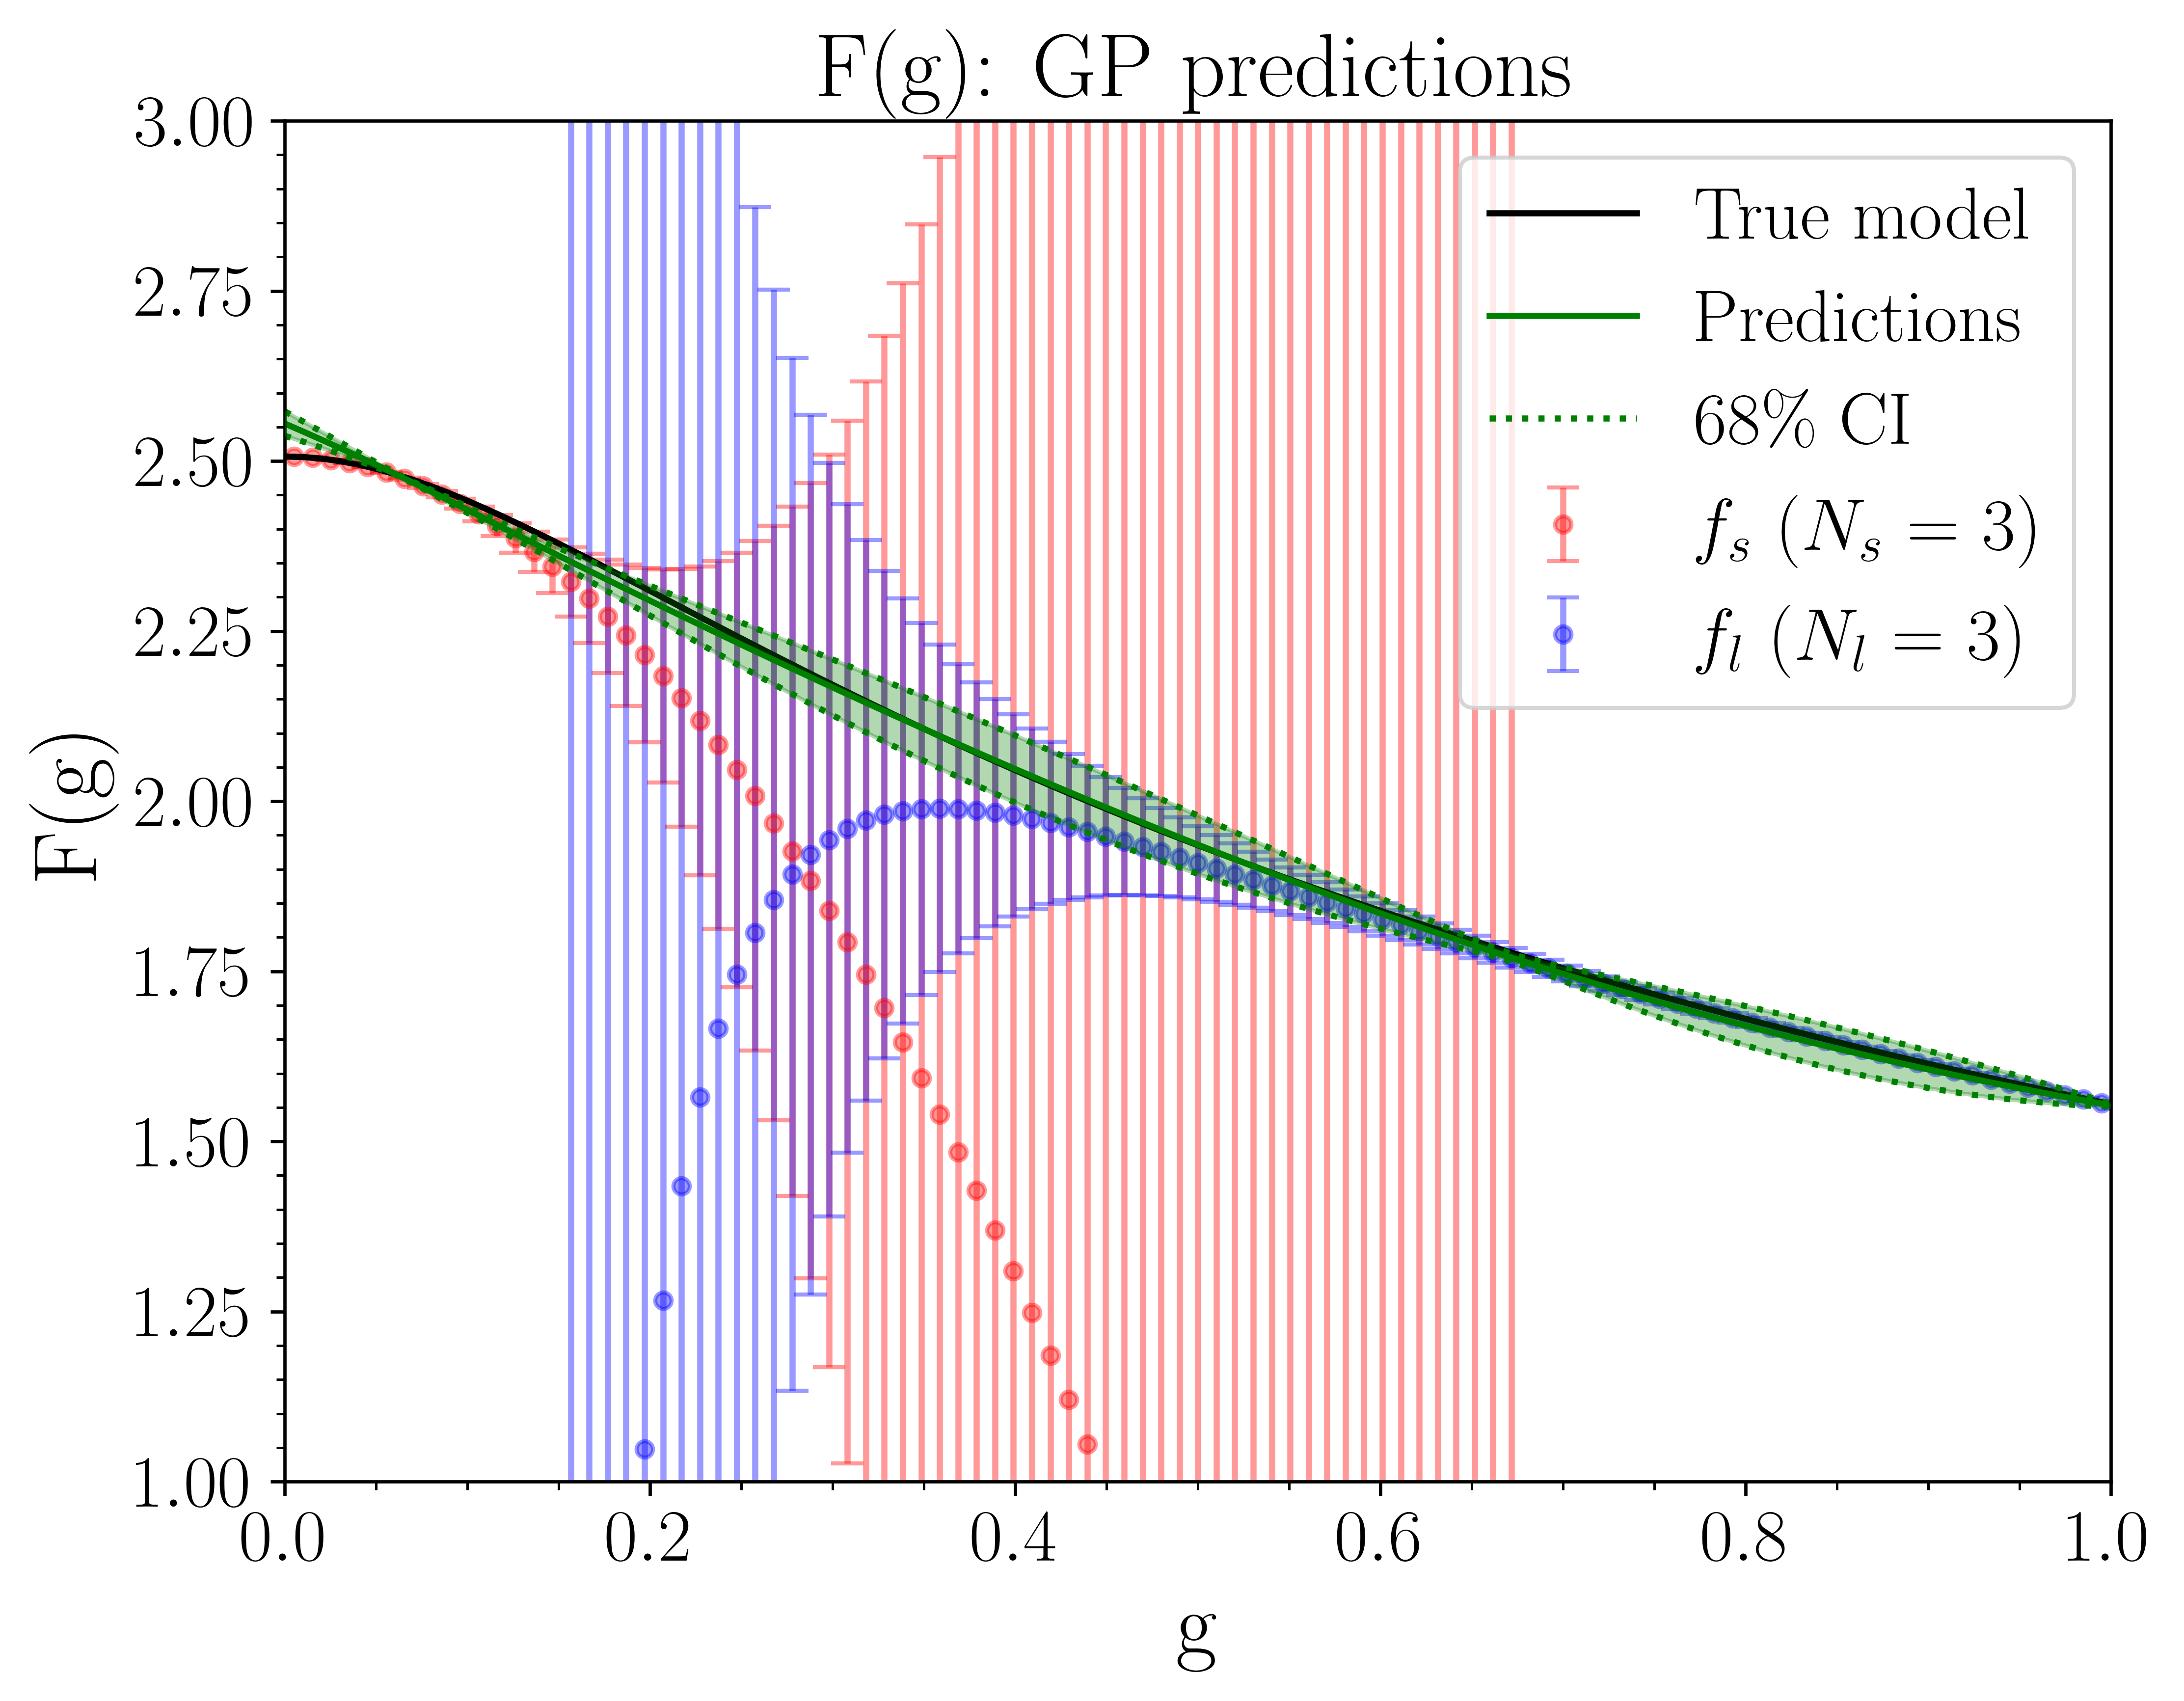

In [20]:
mult_mixed = Multivariate(g, my_models)
_ , mult_mean, mult_intervals, mult_std_dev = mult_mixed.predict(ci=68)

__Note__: The above validation data does NOT have the mixed model included, this just shows the three models separately. We can plot the mixed PPD (posterior predictive distribution) and its credible intervals below. 

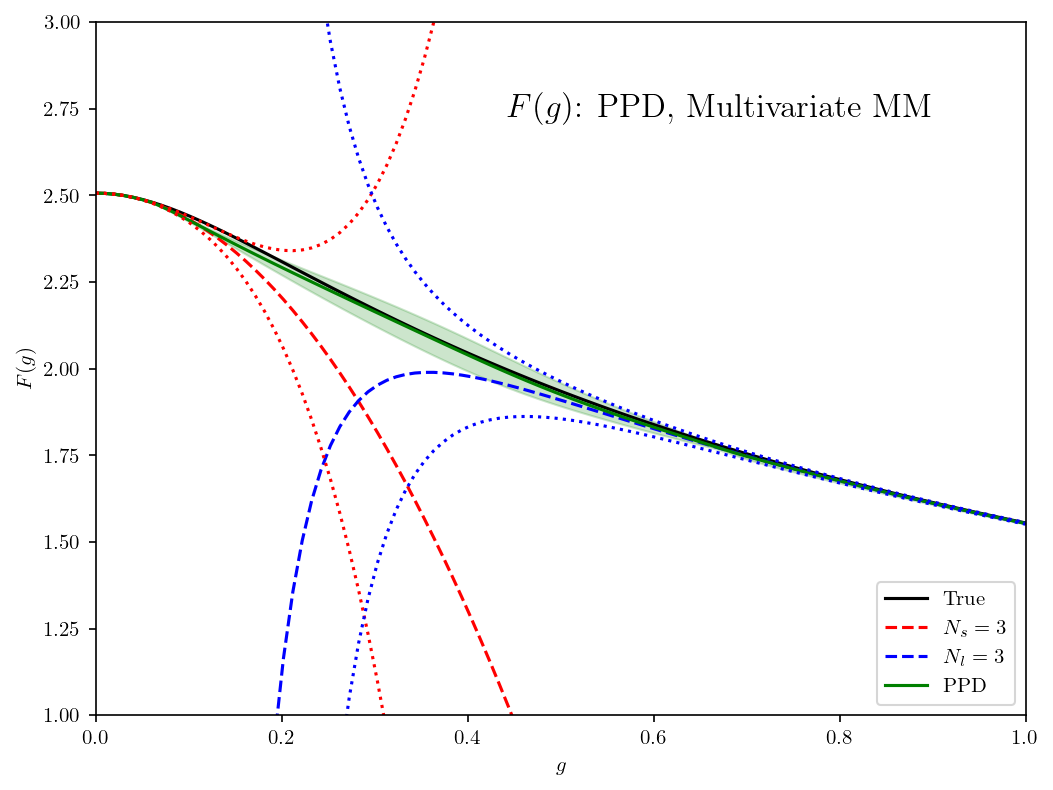

In [21]:
# plot the mixed model including the GP
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.0,3.0)
ax.text(0.9,0.9, r'$F(g)$: PPD, Multivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel(r'$F(g)$')
ax.plot(g, samba_models.true_model().evaluate(g)[0].flatten(), color='k', label='True')

# model means
for i in range(len(model_results)):
      ax.plot(g, model_results[i][0].flatten(), color=colors[i], linestyle=lines[0], label=labels[i])

# PPD mean
ax.plot(g, mult_mean, color=colors[2], label='PPD')
        
# model uncertainties
for i in range(len(model_results)):
    ax.plot(g, model_results[i][0].flatten() - model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    ax.plot(g, model_results[i][0].flatten() + model_results[i][1].flatten(), color=colors[i], linestyle=lines[1])
    
# PPD band
ax.fill_between(g, mult_mean-mult_std_dev, mult_mean+mult_std_dev,
                        zorder=i-5, facecolor=colors[2], edgecolor=colors[2], alpha=0.2)

# legend
ax.legend(loc='lower right')
plt.show()

This is excellent! Now we have results for the PPD with a GP as an interpolant model between the two original toy models. We can check out the weights from these models to see what they look like. 

### Weights: including a GP

We use the same procedure as before and call the `evaluate_weights` function from the `Multivariate` Taweret class.

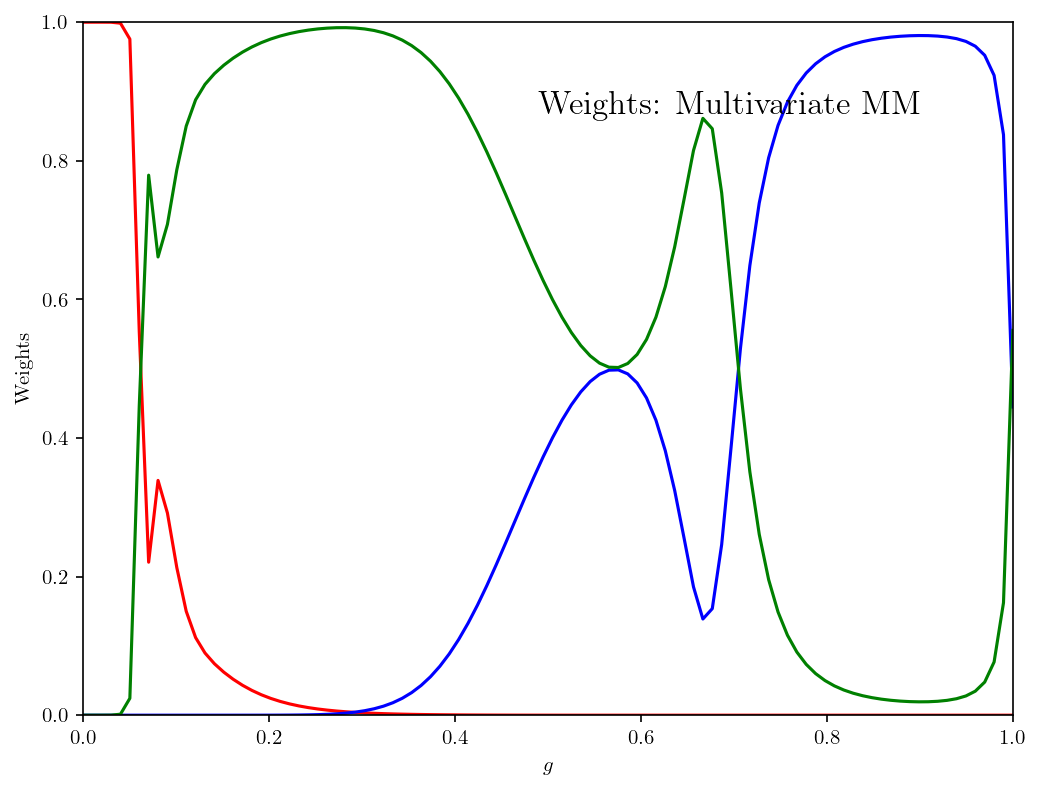

In [22]:
# call the evaluate_weights function
weights = mult_mixed.evaluate_weights()

# plot the weights
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
ax.text(0.9,0.9, 'Weights: Multivariate MM', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$g$')
ax.set_ylabel('Weights')

# model weights
for i in range(len(weights)):
    ax.plot(g, weights[i], color=colors[i])

# legend
#ax.legend(loc='lower right')
plt.show()

__Some questions for you to answer:__

1). When using $N_{s} = 3$ and $N_{l} = 3$, you can see that the curves dip down towards $-\infty$. Why does this __not__ affect the result from Taweret? In other words, why does the PPD curve not dip with the models as it did in the previous example (bivariate mixing without a GP)?

2). How does the result change if I use a different kernel than the Matern kernel, say the RBF one we explored earlier? Change the kernel to 'RBF' and see what happens!

3). How does the result look if you change the truncation order of one or both of the models? For example, you can change $N_{s}$ to 5, and $N_{l}$ to 7, or something like that.

---

Jupyter notebook written by: Alexandra Semposki
SAMBA package written by: Alexandra Semposki
Taweret package written by: Dan Liyanage, Alexandra Semposki, John Yannotty, and Kevin Ingles